## PART II: Multi Layer Perceptron (MLP)

> This implementation is based along the lines of [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

<img src="../assets/neural-prob-LM.jpg" width="400"/>

### Reading and exploring the dataset

In [1]:
import json

names = json.loads(open("names.txt", "r").read())
names = names["payload"]["blob"]["rawLines"]
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [2]:
len(names)

32033

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(names))))
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi["."] = 0
itoch = {i:ch for ch, i in chtoi.items()}

### Building the training dataset

In [28]:
import torch

def build_dataset(words, context_len=3):
    """
    Builds the dataset from the given list of words.

    Args:
        words (list): list of words to use
        context_len (int): length of the context window (default: 3)
    """

    X, y = [], []

    for name in words:
        context = [0] * context_len
        for ch in name + ".":
            ix = chtoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    y = torch.tensor(y)

    return X, y

In [29]:
X, y = build_dataset(names[:5])
X.shape, X.dtype, y.shape, y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

### Implementing the embedding lookup table

In [6]:
C = torch.randn(27, 2)     # randomly-initialized embedding matrix (27 characters, 2 dimensions)
emb = C[X]                 # embeddings for the input sequence
emb.shape, emb[1]

(torch.Size([228146, 3, 2]),
 tensor([[-0.8332, -0.9162],
         [-0.8332, -0.9162],
         [ 0.6978, -0.1664]]))

### Implementing the non-linearity (tanh hidden layer)

In [7]:
print(emb.shape[1:])                             # number of inputs: 2-d embeddings * 3 context characters

first_element = emb.shape[1:][0]
second_element = emb.shape[1:][1]

# Multiplying the numbers
inputs = first_element * second_element
inputs

torch.Size([3, 2])


6

In [8]:
n_neurons = 100                                  # number of neurons in the hidden layer

W1 = torch.randn(inputs, n_neurons)              # randomly-initialized hidden layer weights (6 inputs, 100 neurons)
b1 = torch.randn(n_neurons)                      # randomly-initialized hidden layer biases (100 neurons)
h = torch.tanh(emb.view(-1, inputs) @ W1 + b1)   # hidden layer activations
h.shape, h[1]

(torch.Size([228146, 100]),
 tensor([-0.1575, -0.9975, -0.5686,  0.9949,  0.9364, -0.8390, -0.8760, -0.9975,
          0.8544,  0.9790,  0.9999, -0.4201, -0.9903,  0.0048, -0.4109,  0.6189,
          0.8224,  0.9960, -0.7742,  0.9978,  0.9470, -0.8997, -0.9989,  0.3712,
         -0.9719,  0.9975,  0.6938, -0.7094,  0.9987,  0.1974, -0.9763,  0.8822,
          0.9228, -0.7877,  0.7906,  0.9820, -0.8895, -0.9999,  0.7098,  0.2722,
         -0.4884, -0.1765,  0.4159,  0.9183,  0.3755, -0.6907, -0.9369,  0.5613,
          0.8820,  0.9629, -0.9157, -0.9894,  0.4654, -0.9971,  0.4374,  0.0514,
         -0.9294, -0.9997, -0.8662, -0.4156,  0.9925, -0.7459,  0.9614, -0.7870,
         -0.0106,  0.9570,  0.9259, -0.8807, -0.8944, -0.1596,  0.9987,  0.8033,
         -0.9916,  0.7639, -0.8138, -0.9959, -0.9997,  0.2371, -0.8235,  0.4910,
          0.9897, -0.8142, -0.8223, -0.9997, -0.9994, -0.9955,  0.9918,  0.8301,
         -0.9544, -0.9987, -0.7247, -0.3761, -0.1783,  0.4299,  0.6258, -0.8503,


### Implementing the output layer

> **About logits exponentiation:** The softmax function is often used in the final layer of a neural network-based classifier and consists of a function that turns a vector of real values into a vector of probabilities that sum to 1.

> The exponentiation is applied to ensure that all values become positive, as softmax is sensitive to the scale of the input values. Exponentiation also helps to emphasize the differences between the logits, making it easier to distinguish and highlight the higher-scoring logits. It's important to note that the relative order of the logits remains the same after exponentiation, so the model's ability to discriminate between classes is preserved.

In [9]:
W2 = torch.randn(100, 27)                     # randomly-initialized output layer weights (100 neurons, 27 outputs)
b2 = torch.randn(27)                          # randomly-initialized output layer biases (27 outputs)

logits = h @ W2 + b2                          # output layer activations
logits.shape, logits[1]

(torch.Size([228146, 27]),
 tensor([  3.2862,  11.4991, -12.4459,  -2.6497,   2.7653,  -8.8691, -18.1701,
         -13.0208, -16.1197,   0.4059,  -3.0442,  -8.3563,  -5.0531,   5.4852,
          24.0950, -15.0772,   1.6255,   4.4704,   3.4148,  -6.4985,  -2.5159,
          -2.0221,  -7.4010, -15.4985,   2.0026,  -3.5938,   1.9887]))

In [10]:
counts = logits.exp()                        # convert activations to counts
prob = counts / counts.sum(1, keepdims=True) # softmax
prob.shape, prob[1].sum(), prob[1]

(torch.Size([228146, 27]),
 tensor(1.),
 tensor([9.1804e-10, 3.3860e-06, 1.3505e-16, 2.4263e-12, 5.4531e-10, 4.8291e-15,
         4.4107e-19, 7.5999e-17, 3.4276e-18, 5.1519e-11, 1.6353e-12, 8.0645e-15,
         2.1936e-13, 8.2766e-09, 1.0000e+00, 9.7220e-18, 1.7443e-10, 3.0001e-09,
         1.0440e-09, 5.1691e-14, 2.7735e-12, 4.5444e-12, 2.0963e-14, 6.3791e-18,
         2.5432e-10, 9.4384e-13, 2.5082e-10]))

### Implementing the loss function

In [11]:
y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [12]:
loss = -prob[torch.arange(prob.shape[0]), y].log().mean()
loss

tensor(14.4271)

In [13]:
import torch.nn.functional as F

loss = F.cross_entropy(logits, y)
loss

tensor(14.4271)

### Training using batches

> Once the dataset gets large enough, it becomes feasible to work with batches of data. This is because, in practice, it is computationally expensive to compute the gradients on the full dataset. However, performing training (ie. forward pass, backward pass and parameter update) on a randomly selected batch of data results in good approximations of the gradients computed on the full dataset.

> Because we are using batches of data, the quality of each individual gradient is lower, but the direction of the gradient is good enough to move the parameters towards a local minimum. This is why we see the loss decreasing over time.

<img src="../assets/lecun-batch-size.jpg" width="600"/>

In [31]:
def train(words, inputs, lr=0.01, n_epochs=1000):
    """Trains a neural network language model"""
    X, y = build_dataset(words)
    C = torch.randn(27, 2)
    W1 = torch.randn(6, 100)
    b1 = torch.randn(100)
    W2 = torch.randn(100, 27)
    b2 = torch.randn(27)

    params = [C, W1, b1, W2, b2]

    for p in params:
        p.requires_grad = True

    for _ in range(n_epochs):
        # minibatch construction
        ix = torch.randint(0, X.shape[0], (32,))
        
        # forward pass
        emb = C[X[ix]]
        h = torch.tanh(emb.view(-1, inputs) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y[ix])

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()

        # parameter updates
        for p in params:
            p.data -= lr * p.grad

    print("loss:", loss.item())

In [32]:
train(names, inputs)

loss: 3.11824107170105


### Establishing an appropriate learning rate

> **Important:** Regarding working with batches, it is expected that some "noise" will be created in the gradients. This is because the gradients are computed on a subset of the data, and not the full dataset. This is why we see the loss "jumping around" during training.

In [33]:
lr_exp = torch.linspace(-3, 0, 1000)
lr_schedule = 10**lr_exp

In [34]:
X, y = build_dataset(names)
C = torch.randn(27, 2)
W1 = torch.randn(6, 100)
b1 = torch.randn(100)
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

lre_epoch = []
lrs_epoch = []
loss_epoch = []

for epoch in range(1000):
    # minibatch construction
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, inputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y[ix])

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # parameter updates
    for p in params:
        p.data -= lr_schedule[epoch] * p.grad

    # track stats
    lre_epoch.append(lr_exp[epoch])
    lrs_epoch.append(lr_schedule[epoch])
    loss_epoch.append(loss.item())

print("loss:", loss.item())

loss: 8.541800498962402


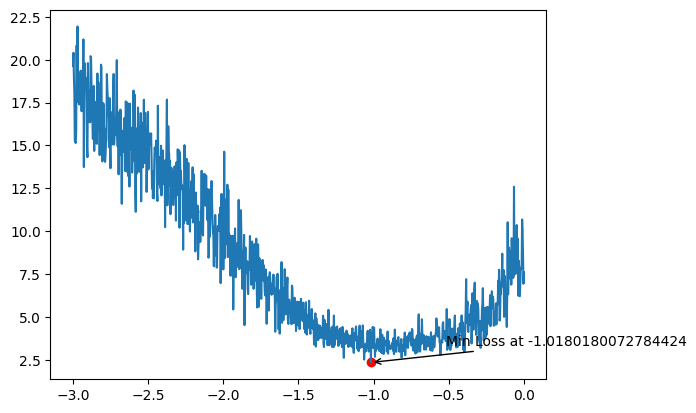

In [20]:
import matplotlib.pyplot as plt

min_loss_index = loss_epoch.index(min(loss_epoch))

plt.plot(lre_epoch, loss_epoch)
plt.scatter(lre_epoch[min_loss_index], loss_epoch[min_loss_index], color='red')
plt.annotate(f'Min Loss at {lre_epoch[min_loss_index]}', 
             xy=(lre_epoch[min_loss_index], loss_epoch[min_loss_index]),
             xytext=(lre_epoch[min_loss_index] + 0.5, loss_epoch[min_loss_index] + 1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.show();

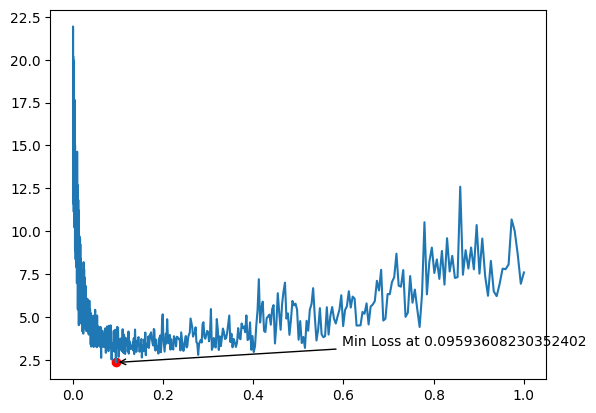

In [21]:
plt.plot(lrs_epoch, loss_epoch)
plt.scatter(lrs_epoch[min_loss_index], loss_epoch[min_loss_index], color='red')
plt.annotate(f'Min Loss at {lrs_epoch[min_loss_index]}', 
             xy=(lrs_epoch[min_loss_index], loss_epoch[min_loss_index]),
             xytext=(lrs_epoch[min_loss_index] + 0.5, loss_epoch[min_loss_index] + 1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.show();

### Retraining using an appropriate learning rate

In [50]:
def lrs_train(data, lr=0.01, emb_len=2, n_neurons=100, n_epochs=10000, rounds=10):
    """
    Trains a neural network language model with learning rate scheduling.

    Args:
        data: list of names to train on
        lr: learning rate (default: 0.01)
        emb_len: embeddings length (default: 2)
        n_neurons: number of neurons in the hidden layer (default: 100)
        n_epochs: number of epochs to train for (default: 10000)
        rounds: number of training rounds (default: 10)
    """

    VOCABULARY = 27

    X, y = build_dataset(data)
    C = torch.randn(VOCABULARY, emb_len)
    W1 = torch.randn(X.shape[1] * emb_len, n_neurons)
    b1 = torch.randn(n_neurons)
    W2 = torch.randn(n_neurons, VOCABULARY)
    b2 = torch.randn(VOCABULARY)

    params = [C, W1, b1, W2, b2]

    for p in params:
        p.requires_grad = True

    for i in range(rounds):
        for epoch in range(n_epochs):
            # minibatch construction
            ix = torch.randint(0, X.shape[0], (32,))
            
            # forward pass
            emb = C[X[ix]]
            h = torch.tanh(emb.view(-1, inputs) @ W1 + b1)
            logits = h @ W2 + b2
            loss = F.cross_entropy(logits, y[ix])

            # backward pass
            for p in params:
                p.grad = None
            loss.backward()

            # parameter updates
            for p in params:
                _lr = lr if i < 5 else lr/(i-3)
                p.data -= _lr * p.grad     # learning rate decay

        print(f"[INFO] Training round: {i+1}/{10} Loss: {loss.item()}")
    
    return params

In [43]:
loss_epoch.index(min(loss_epoch))
lr = lrs_epoch[min_loss_index]
lrs_train(data=names, lr=lr)

[INFO] Training round: 1/10 Loss: 2.3954102993011475
[INFO] Training round: 2/10 Loss: 2.1747143268585205
[INFO] Training round: 3/10 Loss: 2.446422576904297
[INFO] Training round: 4/10 Loss: 2.6316986083984375
[INFO] Training round: 5/10 Loss: 2.330375909805298
[INFO] Training round: 6/10 Loss: 2.163496971130371
[INFO] Training round: 7/10 Loss: 2.3821017742156982
[INFO] Training round: 8/10 Loss: 2.2504100799560547
[INFO] Training round: 9/10 Loss: 2.0044870376586914
[INFO] Training round: 10/10 Loss: 2.2853739261627197


### Splitting the data into training, validation and test sets

> Neural networs can get very complex and overfit the training data. To avoid this, we can split the data in three sets:

> 1. Training set: used to train the parameters of the model. It usually contains 80% of the data.
> 2. Validation set: used to evaluate the performance of the model during training, and to perform hyperparameter tuning (eg. learning rate, number of epochs, etc.). It usually contains 10% of the data.
> 3. Test set: used to evaluate the final performance of the model. It usually contains 10% of the data.

> Basically, lots of experiments are run on the validation set, and the best model is selected. Then, the test set is used to evaluate the final performance of the model.

In [45]:
import random

random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, ytr = build_dataset(names[:n1])
Xval, yval = build_dataset(names[n1:n2])
Xte, yte = build_dataset(names[n2:])

Xtr.shape, Xval.shape, Xte.shape

(torch.Size([182564, 3]), torch.Size([22826, 3]), torch.Size([22756, 3]))

In [51]:
model_params = lrs_train(data=names[:n1], lr=lr)

[INFO] Training round: 1/10 Loss: 2.4120736122131348
[INFO] Training round: 2/10 Loss: 2.17292857170105
[INFO] Training round: 3/10 Loss: 2.256068706512451
[INFO] Training round: 4/10 Loss: 2.6008431911468506
[INFO] Training round: 5/10 Loss: 2.2795913219451904
[INFO] Training round: 6/10 Loss: 2.352890729904175
[INFO] Training round: 7/10 Loss: 2.4120705127716064
[INFO] Training round: 8/10 Loss: 2.403562068939209
[INFO] Training round: 9/10 Loss: 2.2332568168640137
[INFO] Training round: 10/10 Loss: 2.362532138824463


In [55]:
[C, W1, b1, W2, b2] = model_params

for p in model_params:
    p.requires_grad = True

for i in range(10):
    # minibatch construction
    ix = torch.randint(0, Xval.shape[0], (32,))

    # forward pass
    emb = C[Xval[ix]]
    h = torch.tanh(emb.view(-1, inputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yval[ix])
    print(f"[INFO] Evaluation round: {i+1}/{10} Loss: {loss.item()}")

[INFO] Evaluation round: 1/10 Loss: 2.3030319213867188
[INFO] Evaluation round: 2/10 Loss: 2.0948965549468994
[INFO] Evaluation round: 3/10 Loss: 2.78712797164917
[INFO] Evaluation round: 4/10 Loss: 2.351212978363037
[INFO] Evaluation round: 5/10 Loss: 2.2382023334503174
[INFO] Evaluation round: 6/10 Loss: 2.3115105628967285
[INFO] Evaluation round: 7/10 Loss: 2.4667446613311768
[INFO] Evaluation round: 8/10 Loss: 2.5042338371276855
[INFO] Evaluation round: 9/10 Loss: 2.4007833003997803
[INFO] Evaluation round: 10/10 Loss: 2.459280014038086


### Visualizing the embeddings created by the model

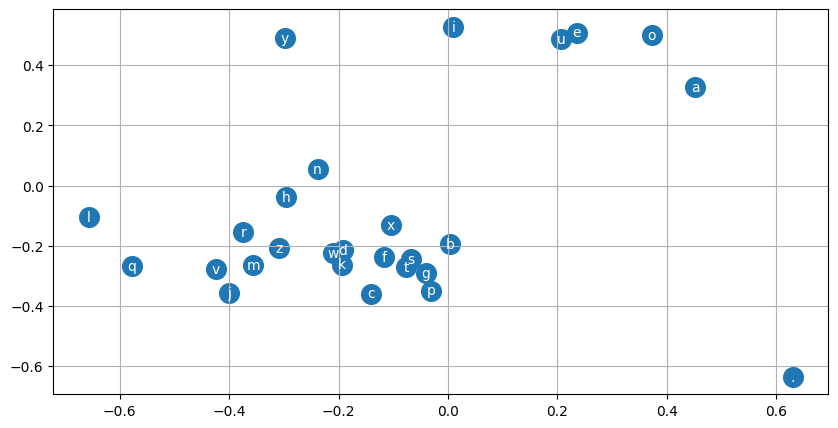

In [56]:
plt.figure(figsize=(10, 5))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itoch[i], ha='center', va='center', color='white')
plt.grid("minor");

### Sampling from the model

In [57]:
CONTEXT_LENGTH = 3

for _ in range(20):
    out = []
    context = [0] * CONTEXT_LENGTH

    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join([itoch[i] for i in out]))

sylin.
midlay.
zellysob.
wooli.
adi.
dian.
chaqmox.
alv.
kale.
kalenn.
diorayahi.
nella.
haid.
licen.
the.
jainy.
hamefbeyah.
zakie.
zys.
ky.


# Sources

1. [Pytorch Internals - Edward Z. Yang](http://blog.ezyang.com/2019/05/pytorch-internals/)
2. [Ground truth - Building makemore Part 2: MLP, By Andrej Karpathy](https://www.youtube.com/watch?v=TCH_1BHY58I&t=2702s)